In [1]:
pip install pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("100k_final_table_for_fd_recommendation_system.csv")
df.columns

Index(['cif_id', 'total_accounts', 'total_saving_accounts',
       'total_fixed_accounts', 'total_loan_accounts',
       'total_overdraft_accounts', 'scheme_type',
       'total_debit_transaction_count', 'total_credit_transaction_count',
       'average_debit_transaction_count', 'average_credit_transaction_count',
       'total_debit_transaction_amount', 'total_credit_transaction_amount',
       'average_debit_amount', 'average_credit_amount',
       'average_yearly_saving', 'total_yearly_saving', 'employment_status',
       'marital_status', 'occupation', 'gender', 'age_group',
       'withdrawal_trends', 'first_account_opened_days',
       'last_account_opened_days', 'first_account_date', 'last_account_date',
       'last_transaction_date', 'last_dormant_date', 'Recently_Active',
       'total_dormant_days', 'total_dormant_account', 'total_active_account'],
      dtype='object')

In [4]:
df.columns = df.columns.str.split('.').str[-1]
df.columns

Index(['cif_id', 'total_accounts', 'total_saving_accounts',
       'total_fixed_accounts', 'total_loan_accounts',
       'total_overdraft_accounts', 'scheme_type',
       'total_debit_transaction_count', 'total_credit_transaction_count',
       'average_debit_transaction_count', 'average_credit_transaction_count',
       'total_debit_transaction_amount', 'total_credit_transaction_amount',
       'average_debit_amount', 'average_credit_amount',
       'average_yearly_saving', 'total_yearly_saving', 'employment_status',
       'marital_status', 'occupation', 'gender', 'age_group',
       'withdrawal_trends', 'first_account_opened_days',
       'last_account_opened_days', 'first_account_date', 'last_account_date',
       'last_transaction_date', 'last_dormant_date', 'Recently_Active',
       'total_dormant_days', 'total_dormant_account', 'total_active_account'],
      dtype='object')

In [5]:
len(df.columns)

33

# Data Preprocessing`

In [6]:
numeric_columns = [
    'total_accounts',
    'total_saving_accounts',
    'total_fixed_accounts',
    'total_loan_accounts',
    'total_overdraft_accounts',
    'total_debit_transaction_count',
    'total_credit_transaction_count',
    'average_debit_transaction_count',
    'average_credit_transaction_count',
    'total_debit_transaction_amount',
    'total_credit_transaction_amount',
    'average_debit_amount',
    'average_credit_amount',
    'average_yearly_saving',
    'total_yearly_saving',
    'total_dormant_account',
    'total_dormant_days',
    'total_active_account'
]

categorical_columns = [
    'employment_status',
    'marital_status',
    'occupation',
    'gender',
    'age_group',
    'withdrawal_trends',
    'scheme_type',
    'Recently_Active'
]


# Handle Missing Values explicitly.

In [7]:
# Numeric columns (median)
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert explicitly
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns (mode)
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipykernel_986/839300990.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_986/839300990.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [8]:
# Label Encoding for binary categorical columns
from sklearn.preprocessing import LabelEncoder

binary_cols = ['gender', 'Recently_Active']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding for other categorical variables
df = pd.get_dummies(df, columns=[
    'occupation',
    'employment_status',
    'marital_status',
    'age_group',
    'withdrawal_trends',
    'scheme_type'
], drop_first=True)


In [9]:
# Drop non-numeric columns explicitly (dates, IDs) before scaling:

exclude_columns = ['cif_id', 'first_account_date', 'last_account_date', 
                   'last_transaction_date', 'last_dormant_date']

# Create features DataFrame explicitly
features = df.drop(columns=exclude_columns, errors='ignore')


# Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


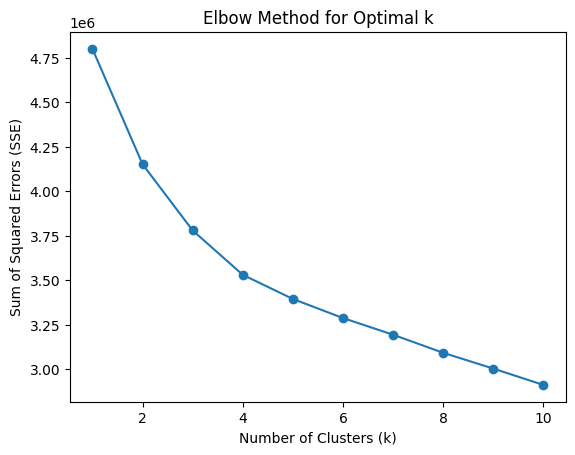

In [11]:
# Identify Optimal Number of Clusters (k)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

# X_scaled= X_scaled[:10000]  # take the first 10k samples to speed up the process

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


In [15]:
# Fit K-Means Clustering with Optimal k

optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


# Evaluate cluster quality

In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("Cluster Validation Metrics:")
print(f"Inertia (SSE): {kmeans.inertia_:.2f}")
print("Silhouette Score:", silhouette_score(X_scaled, df['Cluster']))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, df['Cluster']))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, df['Cluster']))



Cluster Validation Metrics:
Inertia (SSE): 3194779.60
Silhouette Score: 0.1661899814125987
Davies-Bouldin Index: 2.1686589585621903
Calinski-Harabasz Index: 8373.599450099231


 # Visualize Clusters (PCA)

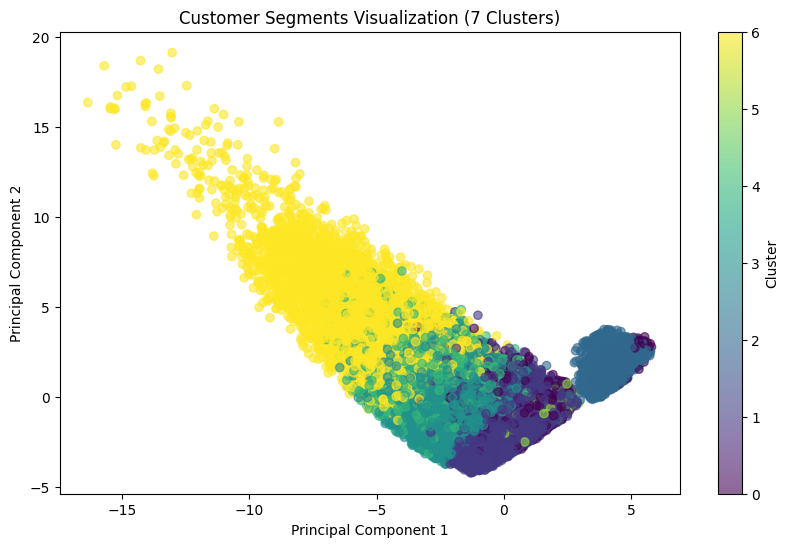

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segments Visualization (7 Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Interpret and Analyze Clusters

In [20]:
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)
print("Cluster-wise Mean Summary:")
cluster_summary


Cluster-wise Mean Summary:


,total_accounts,total_saving_accounts,total_fixed_accounts,total_loan_accounts,total_overdraft_accounts,total_debit_transaction_count,total_credit_transaction_count,average_debit_transaction_count,average_credit_transaction_count,total_debit_transaction_amount,...,employment_status_Unemployed,marital_status_Married,marital_status_Single,marital_status_Widowed,age_group_Gen X,age_group_Gen Y,age_group_Gen Z,age_group_Minor,withdrawal_trends_Low Withdrawal,withdrawal_trends_Moderate Withdrawal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,4.341336,1.491191,1.405227,0.971539,0.473379,44.919071,19.847822,4.461762,1.970184,114576.042396,...,0.064279,0.604647,0.295837,0.034656,0.245305,0.258664,0.151791,0.049564,0.835431,0.164376
1,4.497279,1.498931,1.502693,0.996922,0.498732,47.158778,17.763087,4.492976,1.691277,100368.135558,...,0.000000,0.638361,0.269284,0.026586,0.265409,0.274072,0.122446,0.015872,1.000000,0.000000
2,1.507126,1.506520,0.000559,0.000047,0.000000,13.489661,6.001537,4.500931,1.995389,17164.267744,...,0.999441,0.246787,0.700633,0.021516,0.000000,0.000000,0.411652,0.588348,1.000000,0.000000
3,4.495600,1.497956,1.494542,0.995528,0.507573,46.705727,26.420157,4.450594,2.514449,222072.752165,...,0.000000,0.616387,0.291725,0.028562,0.253498,0.266240,0.163966,0.014425,0.000048,0.999231
4,4.480225,1.498400,1.492768,0.989249,0.499808,47.905670,20.911174,4.569820,1.993344,355249.834324,...,0.000000,0.645335,0.265455,0.026238,0.272879,0.267759,0.109049,0.018687,0.108665,0.891335
5,4.501597,1.494409,1.519169,0.988818,0.499201,46.712460,21.020767,4.460064,2.003195,38418.442812,...,0.000000,0.267572,0.686901,0.017572,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
6,4.504044,1.508088,1.504876,0.991794,0.499286,52.756898,23.048287,4.625476,2.017245,776229.463654,...,0.000000,0.630352,0.273430,0.031874,0.273073,0.264272,0.132255,0.017127,0.006541,0.905923


# Hyperparameter Tuning

In [21]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_clusters': [3,4,5,6],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

best_score = -1
best_kmeans = None
best_params = None

for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'Params: {params}, Silhouette Score: {score:.4f}')

    if score > best_score:
        best_score = score
        best_params = params
        best_kmeans = kmeans

print("\nBest Parameters:", best_params)
print("Best Silhouette Score:", best_score)

df['Cluster'] = best_kmeans.labels_


Params: {'init': 'k-means++', 'n_clusters': 3, 'n_init': 10}, Silhouette Score: 0.1579
Params: {'init': 'k-means++', 'n_clusters': 3, 'n_init': 20}, Silhouette Score: 0.1579
Params: {'init': 'k-means++', 'n_clusters': 4, 'n_init': 10}, Silhouette Score: 0.1543
Params: {'init': 'k-means++', 'n_clusters': 4, 'n_init': 20}, Silhouette Score: 0.1543
Params: {'init': 'k-means++', 'n_clusters': 5, 'n_init': 10}, Silhouette Score: 0.1556
Params: {'init': 'k-means++', 'n_clusters': 5, 'n_init': 20}, Silhouette Score: 0.1556
Params: {'init': 'k-means++', 'n_clusters': 6, 'n_init': 10}, Silhouette Score: 0.1483
Params: {'init': 'k-means++', 'n_clusters': 6, 'n_init': 20}, Silhouette Score: 0.1567
Params: {'init': 'random', 'n_clusters': 3, 'n_init': 10}, Silhouette Score: 0.1579
Params: {'init': 'random', 'n_clusters': 3, 'n_init': 20}, Silhouette Score: 0.1579
Params: {'init': 'random', 'n_clusters': 4, 'n_init': 10}, Silhouette Score: 0.1543
Params: {'init': 'random', 'n_clusters': 4, 'n_init'

In [ ]:
#  Final Cluster Profile & Actionable Insights

In [ ]:
# cluster_summary = df.groupby('Cluster').mean()
# print("Detailed Cluster Summary:")
# print(cluster_summary)


#  K-Modes clustering on your encoded categorical columns:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
import pandas as pd

# Prepare data
categorical_columns = [
    'employment_status',
    'marital_status',
    'occupation',
    'gender',
    'age_group',
    'withdrawal_trends',
    'scheme_type',
    'Recently_Active'
]

encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(df[categorical_columns])

# Perform clustering
kmodes = KModes(n_clusters=7, init='Huang', verbose=1, random_state=42)
clusters = kmodes.fit_predict(categorical_encoded.toarray())

# Attach clusters back to the original dataframe
df['Cluster_Categorical'] = clusters


# Cluster-wise Descriptive Analysis

In [ ]:
cluster_summary = df.groupby('Cluster').agg({
    'total_accounts': 'mean',
    'total_saving_accounts': 'mean',
    'total_fixed_accounts': 'mean',
    'total_loan_accounts': 'mean',
    'total_overdraft_accounts': 'mean',
    'average_debit_transaction_count': 'mean',
    'average_credit_transaction_count': 'mean',
    'total_debit_transaction_amount': 'mean',
    # add other important numeric features...
})

print(cluster_summary)


# Visualizing Feature Distributions per Cluster

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Cluster', y='total_debit_transaction_amount', data=df)
plt.title('Debit Transaction Amount by Cluster')
plt.show()
